In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from Deep_Learning.Experimental.Boltzmann.train import train, eval
from Deep_Learning.Experimental.Boltzmann.model import FCBoltzmannModel
from Utils.dataset import PreloadedDataset

In [2]:
# device = torch.device('cuda') if torch.cuda.is_available() else "cpu"ArithmeticError
device = torch.device('cpu')
device

device(type='cpu')

In [3]:
# Sets vals < 0.0 -> 0.0 and vals >= 0.0 -> 1.0
class HopfieldActivation():
    def __call__(self, x, _=None):
        return hopfield_activation(x)

def hopfield_activation(x: torch.Tensor, threshold:float=0.0):
    x = torch.clamp(x, max=0.0)
    x = torch.sign(x)
    x += 1.0
    return x

class MixSamples():
    def __init__(self, dataset):
        self.dataset = dataset
        self.n = len(dataset)
    def __call__(self, x, _=None):
        i = torch.randint(0, self.n-1, (1,)).item()
        return mix_images(x, self.dataset[i][0])

def mix_images(x1, x2, steps=10):
    mask = torch.bernoulli(torch.ones((28,28))*0.5).unsqueeze(0).unsqueeze(0)
    # blur  with a filter of the form [1/4, 1/2, 1/4] in both horizontal and veritical directions
    filter_h = torch.tensor([[1/4, 1/2, 1/4]])
    filter_v = torch.tensor([[1/4], [1/2], [1/4]])
    for _ in range(5):
        mask = F.conv2d(mask, filter_h.unsqueeze(0).unsqueeze(0), padding='same')
        mask = F.conv2d(mask, filter_v.unsqueeze(0).unsqueeze(0), padding='same')
    
    # threshold at 0.5
    mask_1 = mask > 0.5
    mask_2 = mask <= 0.5

    out = x1*mask_1 + x2*mask_2
    return out.squeeze(0)

Loaded MNIST with 16 samples


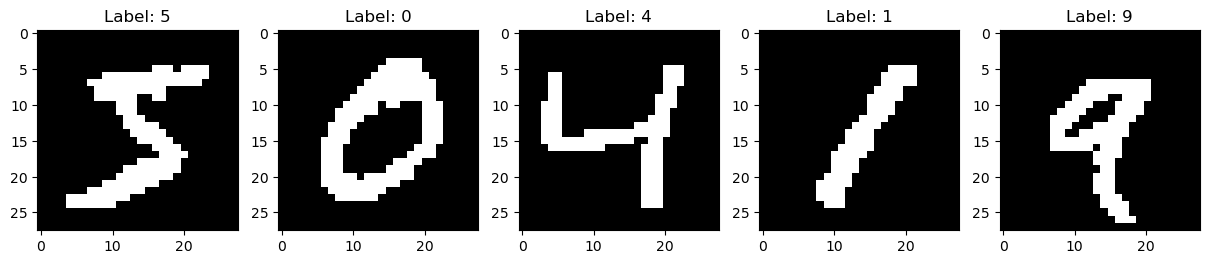

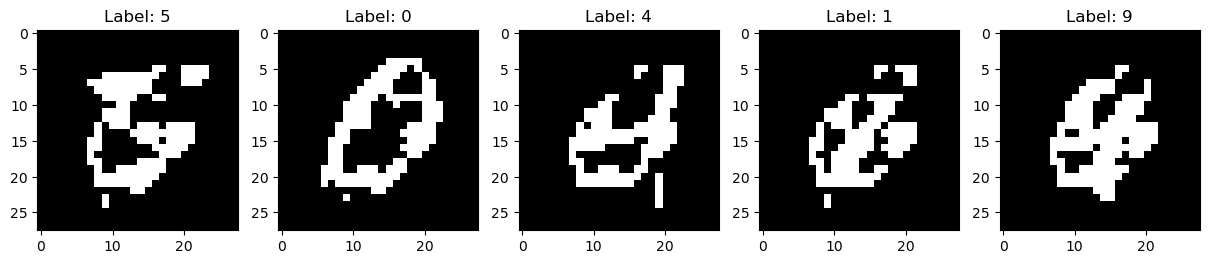

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    HopfieldActivation(),
])

subset_size = 16
dataset = datasets.MNIST(root="../Datasets/", train=True, transform=transform, download=False)
dataset = torch.utils.data.Subset(dataset, range(subset_size))

positive_dataset = PreloadedDataset.from_dataset(dataset, None, device)
negative_dataset = PreloadedDataset.from_dataset(dataset, MixSamples(positive_dataset), device)
print(f'Loaded MNIST with {len(positive_dataset)} samples')

# show first samples positives
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axs[i].imshow(np.squeeze(positive_dataset[i][0].numpy()), cmap='gray')
    axs[i].set_title(f"Label: {positive_dataset[i][1]}")
plt.show()

# show first samples negatives
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axs[i].imshow(np.squeeze(negative_dataset[i][0].numpy()), cmap='gray')
    axs[i].set_title(f"Label: {negative_dataset[i][1]}")
plt.show()

In [11]:
eval_criterion=nn.MSELoss()
model = FCBoltzmannModel(784, 32, [256])
step = 0

In [12]:
batch_size = 16
positive_dataloader = torch.utils.data.DataLoader(positive_dataset, batch_size=batch_size, shuffle=True)
negative_dataloader = torch.utils.data.DataLoader(negative_dataset, batch_size=batch_size, shuffle=True)

In [13]:
learning_rate = 0.1
epochs = 100
train(
    model, 
    positive_dataloader, 
    negative_dataloader, 
    eval_criterion, 
    learning_rate, 
    epochs, 
    neg_every=1,
    neg_num=10000,
    model_params=[100, (2.0, 2.0), False],
    eval_every=5,
    step=step
)

([tensor(0.5056),
  tensor(0.5611),
  tensor(0.5848),
  tensor(0.5883),
  tensor(0.5875),
  tensor(0.5884),
  tensor(0.5897),
  tensor(0.5876),
  tensor(0.5889),
  tensor(0.5888),
  tensor(0.5891),
  tensor(0.5880),
  tensor(0.5871),
  tensor(0.5864),
  tensor(0.5871),
  tensor(0.5854),
  tensor(0.5847),
  tensor(0.5843),
  tensor(0.5814),
  tensor(0.5797)],
 1600)

In [19]:
a = torch.randn((5,5))
b = torch.randn((5,5))
torch.equal(a,b)

False